ปฏิบัติการครั้งที่ 8 กระบวนวิชา 229351 Statistical Learning for Data Science

คำชี้แจง

1. ให้เริ่มทำปฏิบัติการจาก colab notebook ที่กำหนดให้
2. ตั้งค่าใน Colab ให้สามารถ share ไฟล์ได้
3. ส่งใน Mango

ดาวน์โหลดข้อมูลการขายรถยนต์ใน link ข้างล่างนี้  
https://donlapark.pages.dev/229351/data/CarSales.csv  

In [ ]:
!wget -O CarSales.csv https://donlapark.pages.dev/229351/data/CarSales.csv

--2024-02-08 04:11:16--  https://donlapark.pages.dev/229351/data/CarSales.csv
Resolving donlapark.pages.dev (donlapark.pages.dev)... 172.66.47.56, 172.66.44.200, 2606:4700:310c::ac42:2f38, ...
Connecting to donlapark.pages.dev (donlapark.pages.dev)|172.66.47.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1834 (1.8K) [text/csv]
Saving to: ‘CarSales.csv’

CarSales.csv        100%[===================>]   1.79K  --.-KB/s    in 0s      

2024-02-08 04:11:16 (18.7 MB/s) - ‘CarSales.csv’ saved [1834/1834]



In [ ]:
# import module ที่ต้องใช้
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
# ฟังก์ชันที่เปลี่ยน string ให้เป็น datetime
def parser(dates):
  return datetime.strptime(dates, '%Y-%m')

# parse_dates ชื่อของคอลัมน์ที่จะเปลี่ยนให้เป็น datetime
# index_col ชื่อของคอลัมน์ที่จะให้เป็น index
# date_parser ฟังก์ชันที่เปลี่ยน string ให้เป็น datetime
data = pd.read_csv('CarSales.csv', parse_dates=['Month'],
                                        index_col='Month',
                                        date_parser=parser)

print (data.tail())

            Sales
Month            
1968-08-01  16722
1968-09-01  14385
1968-10-01  21342
1968-11-01  17180
1968-12-01  14577


### Check if the inferred frequency is correct

[list of time series frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases)

In [ ]:
# MS คือ month start frequency (เป็นรายเดือนนับวันที่ 1 ของแต่ละเดือนไปเรื่อยๆ)

In [ ]:
print(data.index.inferred_freq)

MS


In [ ]:
y = data['Sales'].astype('float32')

print(y)

Month
1960-01-01     6550.0
1960-02-01     8728.0
1960-03-01    12026.0
1960-04-01    14395.0
1960-05-01    14587.0
               ...   
1968-08-01    16722.0
1968-09-01    14385.0
1968-10-01    21342.0
1968-11-01    17180.0
1968-12-01    14577.0
Name: Sales, Length: 108, dtype: float32


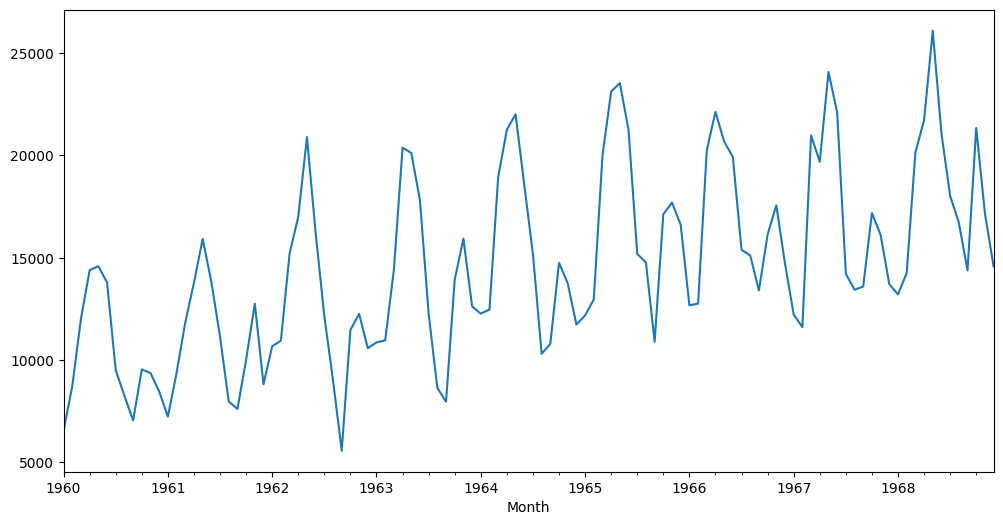

In [ ]:
plt.figure(figsize=(12,6))
y.plot();

In [ ]:
def rmse(y_true,y_pred):
  # Inputs
  # y_true: actual value, y_pred: predicted values
  # Output: RMSE between y_true and y_pred
  return np.sqrt(np.mean(np.square(y_true-y_pred)))

# Train-Test split

In [ ]:
train = y[:-12]
test = y[-12:] # ใช้ 12 เดือนสุดท้าย

print(test)

Month
1968-01-01    13210.0
1968-02-01    14251.0
1968-03-01    20139.0
1968-04-01    21725.0
1968-05-01    26099.0
1968-06-01    21084.0
1968-07-01    18024.0
1968-08-01    16722.0
1968-09-01    14385.0
1968-10-01    21342.0
1968-11-01    17180.0
1968-12-01    14577.0
Name: Sales, dtype: float32


## Holt Winter’s Exponential Smoothing

`ExponentialSmoothing`

### trend : {“add”, “mul”, “additive”, “multiplicative”, None}, optional

    Type of trend component.

### damped : bool, optional

    Should the trend component be damped.

### seasonal : {“add”, “mul”, None}, optional

    Type of seasonal component.

### seasonal_periods : int, optional

    The number of periods in a complete seasonal cycle, e.g., 4 for quarterly data or 7 for daily data with a weekly cycle.


In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

es = ExponentialSmoothing(train,
                          trend = 'add',
                          damped_trend=True,
                          seasonal=None,
                          seasonal_periods=12)
es_fit = es.fit(optimized=True)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [ ]:
yhat = es_fit.predict('1968-01-01', '1968-12-01')

In [ ]:
yhat

1968-01-01    13681.486340
1968-02-01    13638.568268
1968-03-01    13596.079377
1968-04-01    13554.015375
1968-05-01    13512.372013
1968-06-01    13471.145085
1968-07-01    13430.330426
1968-08-01    13389.923914
1968-09-01    13349.921466
1968-10-01    13310.319043
1968-11-01    13271.112645
1968-12-01    13232.298310
Freq: MS, dtype: float64

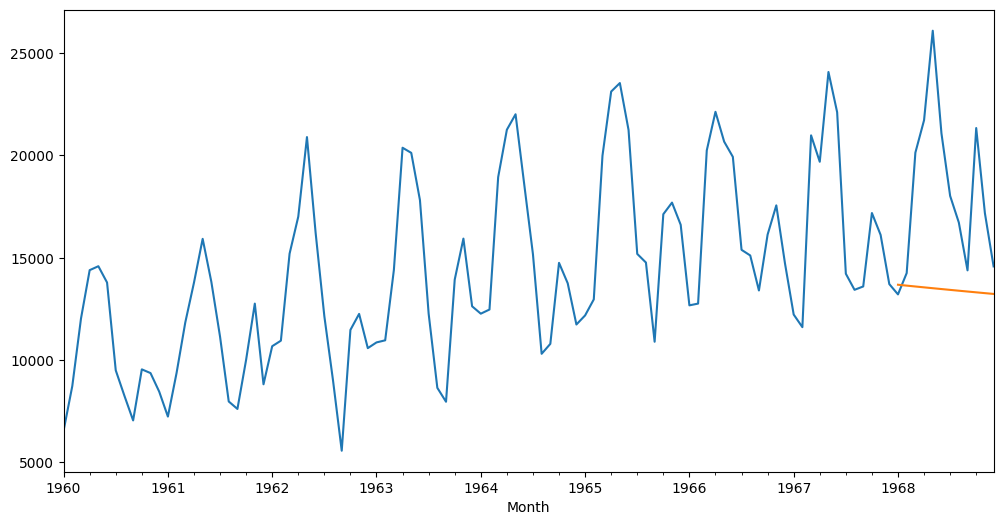

In [ ]:
plt.figure(figsize=(12,6))
y.plot() # ค่าของจริงใน test set
yhat.plot(); # ค่าที่ทำนายได้ (ไม่ดีเพราะเป็นเส้นตรงลงมา เราควรใช้ Holt-Winter's seasonal)

In [ ]:
print('RMSE:',rmse(test,yhat)) # ถ้า model ที่ 2 มีค่า RMSE น้อยกว่าอันนี้ แปลว่า การทำนายดีกว่า

RMSE: 6065.080219245032


In [ ]:
es = ExponentialSmoothing(train,
                          trend = 'add',
                          damped=True,
                          seasonal='mul',
                          seasonal_periods=12)
es_fit = es.fit(optimized=True)
yhat = es_fit.predict('1968-01-01', '1968-12-01')

print('RMSE:',rmse(test,yhat)) # 1995 น้อยกว่า 6065 ถือว่า model นี้ทำได้ดีกว่ามาก

RMSE: 1995.3082169590184


<ipython-input-18-918425fe6d47>:1: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  es = ExponentialSmoothing(train,
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


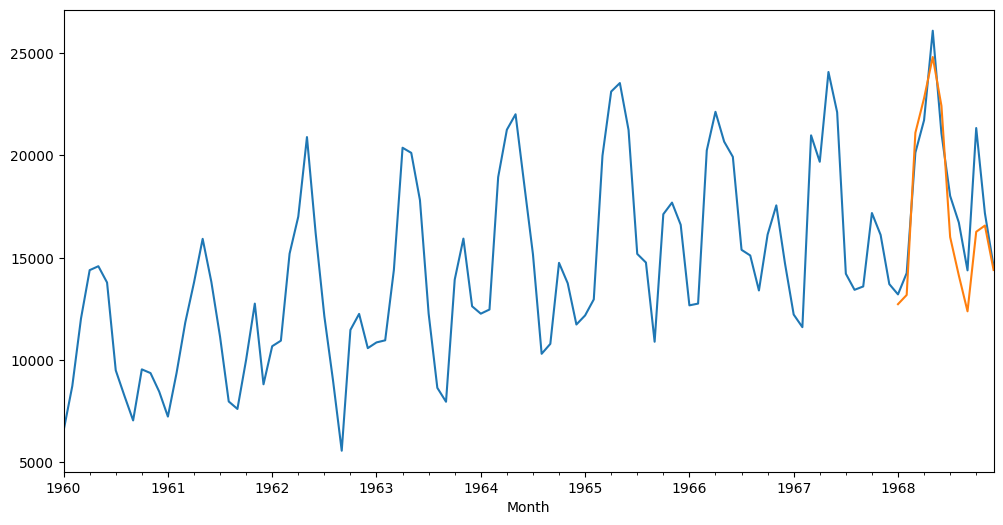

In [ ]:
plt.figure(figsize=(12,6))
y.plot()
yhat.plot(); # ทำนายข้อมูลในปี 1968 ได้อย่างแม่นยำมาก

Check the parameters of the model.

In [ ]:
#list of parameters
es_fit.params

{'smoothing_level': 0.28785714285714287,
 'smoothing_trend': 0.0001,
 'smoothing_seasonal': 0.2967261904761905,
 'damping_trend': 0.99,
 'initial_level': 10165.33055555555,
 'initial_trend': 34.594444444445,
 'initial_seasons': array([0.8041781 , 0.86115571, 1.17382415, 1.39900729, 1.52247314,
        1.27136361, 0.94712638, 0.71107891, 0.58820128, 0.91316305,
        1.00483164, 0.80359672]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

smoothing_level (alpha)

smoothing_trend (beta)

smoothing_seasonal(gamma|phi)

initial_level (l0)

initial_trend (t)

initial_seasons (S)

In [ ]:
es_fit.params["smoothing_level"]

0.28785714285714287